In [1]:
import pandas as pd
from sqlalchemy import create_engine
engine = create_engine('postgresql://postgres@localhost:5432/history')

In [26]:
df = pd.read_sql_query('select * from "gas_station"',con=engine)

Question: How many locations and brands are present in the database?

In [3]:
print('There are', df.shape[0], 'locations belonging to', df["brand"].nunique(), 'brands in the Database.')

There are 15393 locations belonging to 893 brands in the Database.


[]

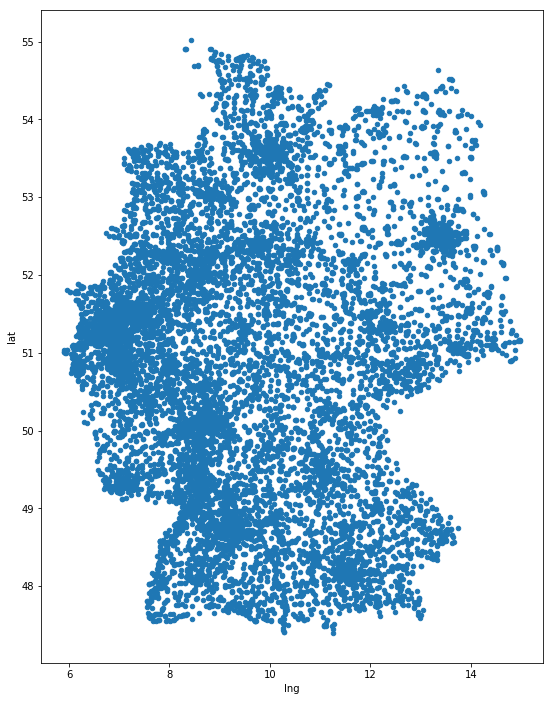

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
res = df[df['lng'] != 0]
germanmap = res.plot(kind="scatter", x="lng", y="lat", figsize=(9,12))
germanmap.plot()

Question: Find Average Cheapest Gas Station for every Autobahn

In [27]:
import re
#Search all Gas Stations where street name is A
df_autobahn = df[df['street'] == 'A']
df_autobahn['house_number'] = df_autobahn['house_number'].map(lambda x: re.sub(r"\D", "", x))

C:\Users\reti\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [34]:
#convert ID's into a list of strings "('a','b','c')" for the SQL Query to fetch prices
autobahn_id_list = df_autobahn.id.tolist()
autobahn_id_list = list(map(str, autobahn_id_list))
query = 'SELECT stid, diesel FROM gas_station_information_history WHERE stid::text IN '
idlist =  '(' + ','.join(["'%s'" % w for w in autobahn_id_list]) + ')'
average_diesel_autobahn = pd.read_sql_query(query+idlist,con=engine)

In [35]:
#now use pandas to calculate the average diesel of each gas station
grouped_average_diesel_autobahn = average_diesel_autobahn.groupby(average_diesel_autobahn['stid'])
mean_grouped_average_diesel_autobahn = grouped_average_diesel_autobahn.mean().reset_index()
mean_grouped_average_diesel_autobahn.columns = ['id', 'diesel']
#now merge with names and adresses belonging to the gas station id's
merged_mean_grouped_average_diesel_autobahn = mean_grouped_average_diesel_autobahn.merge(df_autobahn[['id', 'name', 'street', 'house_number']])
#select cheapest for each autobahn (sort_values().first() = min()) 
grouped = merged_mean_grouped_average_diesel_autobahn.sort_values("diesel").groupby(merged_mean_grouped_average_diesel_autobahn["house_number"], as_index=False).first()
grouped

C:\Users\reti\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\reti\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\reti\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\plotting\_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute 

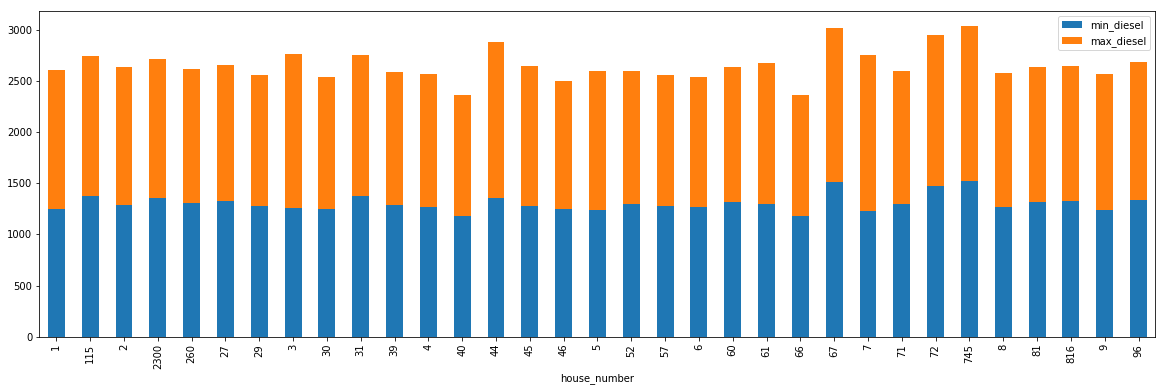

In [85]:
min_max_price = grouped[['id', 'house_number']]
min_max_price['max_diesel'] = merged_mean_grouped_average_diesel_autobahn.sort_values("diesel").groupby(merged_mean_grouped_average_diesel_autobahn["house_number"], 
                                                                                                        as_index=False).last()['diesel']
min_max_price['min_diesel'] = merged_mean_grouped_average_diesel_autobahn.sort_values("diesel").groupby(merged_mean_grouped_average_diesel_autobahn["house_number"], 
                                                                                                        as_index=False).first()['diesel']
min_max_price.house_number.name = 'Autobahn'
min_max_price.sort_values('house_number').plot(x='house_number', y=['min_diesel', 'max_diesel'], kind='bar', stacked=True, figsize=(20, 6))

Question: Find min and max prices for each month

In [56]:
#solved with sql query to do the task, for min operation 888, 0 and -1 were ignored 
min_max_df = pd.read_sql_query("""select extract(month from date) as mon,
               extract(year from date) as yyyy,
               min(NULLIF(NULLIF(NULLIF(diesel, 888), 0), -1)) as "min diesel",
               min(NULLIF(NULLIF(NULLIF(e5, 888), 0), -1)) as "min e5",
               min(NULLIF(NULLIF(NULLIF(e10, 888), 0), -1)) as "min e10",
               max(diesel) as "max diesel",
               max(e5) as "max e5",
               max(e10) as "max e10"
            from gas_station_information_history
            group by 1,2;"""
            ,con=engine)

In [57]:
min_max_df.sort_values(by=['yyyy', 'mon'])

,mon,yyyy,min diesel,min e5,min e10,max diesel,max e5,max e10
8,5.0,2016.0,869,989,999,2099,1999,2000
11,6.0,2016.0,909,1000,919,1999,1999,2000
14,7.0,2016.0,919,999,999,2178,2144,2134
17,8.0,2016.0,899,979,989,2000,2000,2200
20,9.0,2016.0,869,1000,1000,2129,1999,2000
22,10.0,2016.0,889,1000,1069,2119,2169,2000
24,11.0,2016.0,918,889,890,2198,2123,2000
26,12.0,2016.0,869,890,870,2089,2016,2017
0,1.0,2017.0,999,990,980,2189,1999,2000
2,2.0,2017.0,889,990,1000,1999,1999,2000


C:\Users\reti\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\plotting\_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


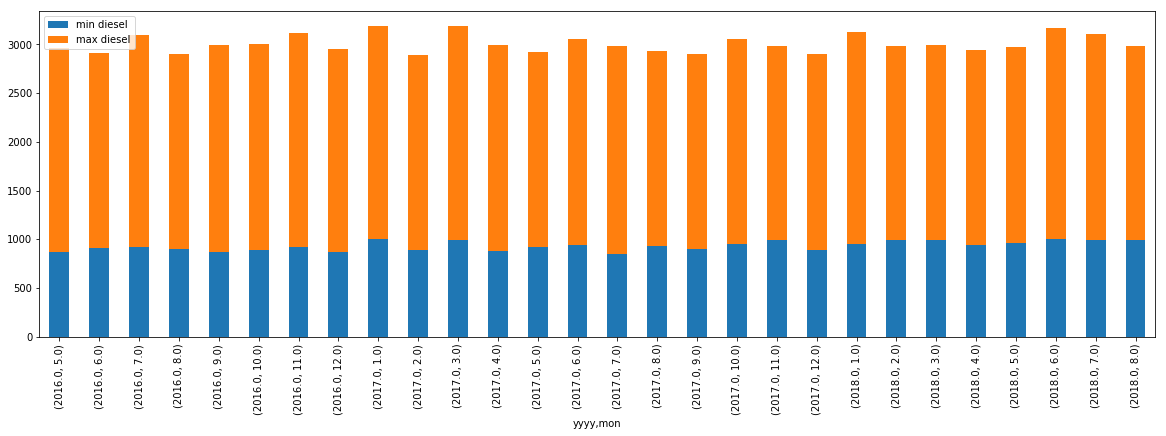

In [62]:
ax = min_max_df.sort_values(by=['yyyy', 'mon']).plot(x=['yyyy', 'mon'], y=['min diesel', 'max diesel'], kind='bar', stacked=True, figsize=(20, 6))
plt.show()

Question: Find cheapest Weekday and Daytime

In [63]:
#NULL is ignored by avg function
avg_dow = pd.read_sql_query("""select extract(dow from date) as dow,
            avg(NULLIF(NULLIF(NULLIF(diesel, 888), 0), -1)) as "avg diesel"
            from gas_station_information_history
            group by 1;""",
            con=engine)

In [65]:
avg_dow.replace([0,1,2,3,4,5,6], ['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

,dow,avg diesel
0,Sunday,1180.731078
1,Monday,1173.059531
2,Tuesday,1172.006497
3,Wednesday,1169.523021
4,Thursday,1169.974539
5,Friday,1170.937489
6,Saturday,1175.252398


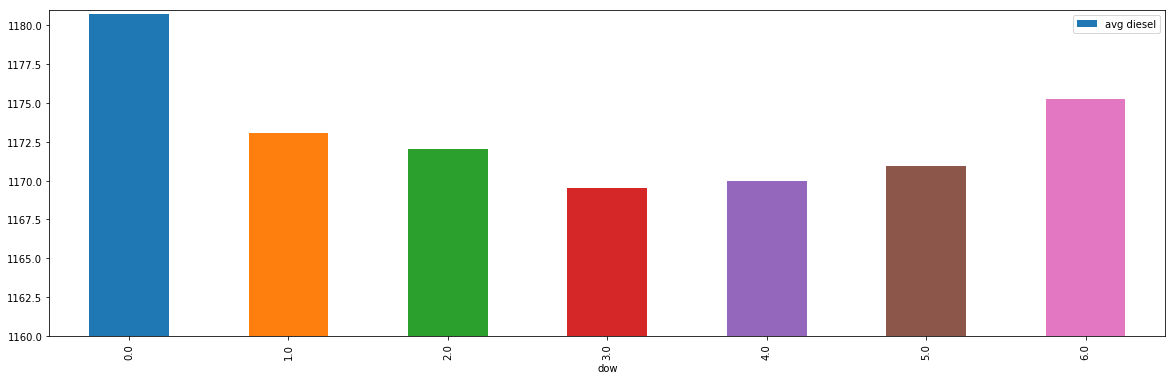

In [78]:
avg_dow.plot(x=['dow'], y='avg diesel', kind='bar', figsize=(20, 6), ylim=(1160, 1181))

In [79]:
avg_h = pd.read_sql_query("""select extract(hour from date) as h,
            avg(NULLIF(NULLIF(NULLIF(diesel, 888), 0), -1)) as "avg diesel"
            from gas_station_information_history
            group by 1;""",
            con=engine)

In [80]:
avg_h.sort_values(by=['avg diesel'])

,h,avg diesel
16,16.0,1134.641123
20,20.0,1141.576241
15,15.0,1144.181253
11,11.0,1148.032996
14,14.0,1153.769433
18,18.0,1155.000158
19,19.0,1155.959605
13,13.0,1158.442773
10,10.0,1159.235316
9,9.0,1170.935511


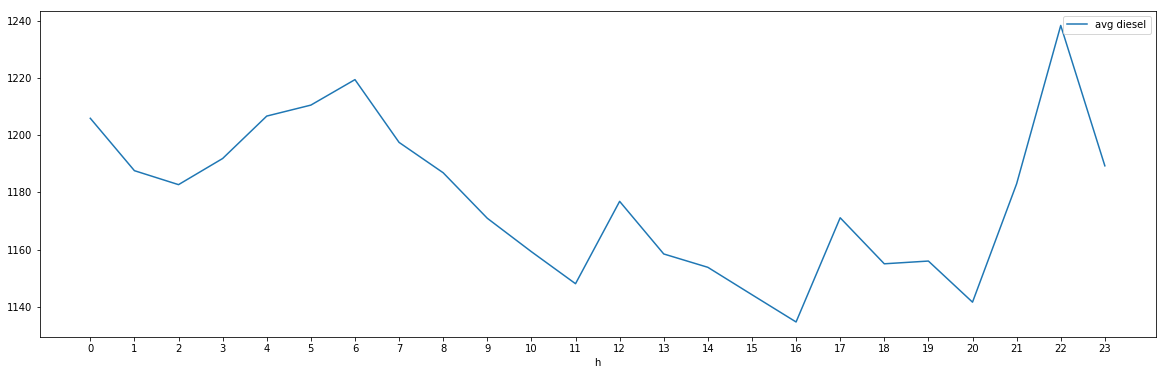

In [91]:
avg_h.sort_values(by=['h']).plot(x='h', y='avg diesel', figsize=(20, 6), xticks=range(0,24))

Question: Find Cheapest Brand

In [25]:
cheapest_brand = pd.read_sql_query("""select gs.brand,
            avg(NULLIF(NULLIF(NULLIF(gsih.diesel, 888), 0), -1)) as "avg diesel" 
            FROM gas_station gs JOIN gas_station_information_history gsih ON gs.id = gsih.stid 
            group by 1;"""
            ,con=engine)

In [33]:
count_brand_locations = pd.read_sql_query("""select count('id'), brand from gas_station group by 2 order by 1 DESC;"""
            ,con=engine)
count_brand_locations[]

,count,brand
0,2376,ARAL
1,1787,Shell
2,1063,ESSO
3,889,TOTAL
4,750,AVIA
5,671,JET
6,566,STAR
7,434,Agip
8,397,Raiffeisen
9,384,HEM


In [42]:
#merge average diesel price of each brand with the count of locations, to filter out small chains (with < 10 locations)
result = pd.merge(cheapest_brand, count_brand_locations, on=['brand']).sort_values(by="avg diesel", ascending=True)
result[result["count"] >= 10]

,brand,avg diesel,count
501,Mr. Wash Autoservice AG,1111.100162,19
586,REWE,1116.108757,15
223,EDEKA,1132.451353,14
187,CleanCar AG,1132.574870,13
220,ED,1138.613323,107
476,LTG,1138.846680,19
411,Hoyer,1140.164987,86
676,Supermarkt-Tankstelle,1141.036686,87
677,"Supermarkt-Tankstelle am real,- Markt",1141.909055,93
244,FAMILA,1142.757547,14


Question: Find Cheapest Gas Station for each region (where region == first three digits of region code)

In [63]:
cheapest_by_region = pd.read_sql_query("""SELECT a.stid, a.name, a.region, a.diesel
            FROM
            (SELECT gsih.stid as stid, left(gs.post_code, 3) as region, gsih.diesel as diesel, gs.name as name 
            FROM gas_station_information_history AS gsih JOIN gas_station AS gs ON gs.id = gsih.stid) a
            JOIN
                (SELECT c.region, min(NULLIF(NULLIF(NULLIF(c.diesel, 888), 0), -1)) as "min_diesel" FROM 
                    (SELECT gsih.stid, left(gs.post_code, 3) as region, gsih.diesel, gs.name FROM gas_station_information_history gsih JOIN gas_station gs ON gs.id = gsih.stid) as c
                GROUP BY 1) b
            ON a.region = b.region AND a.diesel = b.min_diesel;"""
            ,con=engine)

In [73]:
cheapest_by_region.sort_values(by=["region"]).drop_duplicates()

,stid,name,region,diesel
4168,6d4bfcc4-44ba-4884-a8b5-72e36dfb7582,bft Tankstelle,,999
2617,a760b752-1193-4cc7-9cfe-a3440ac79d6a,gelöscht,000,959
978,e1a15081-260f-9107-e040-0b0a3dfe563c,"Dresden, Hansastr. 72",010,989
902,005056ba-7cb6-1ed2-bceb-bf01ea42cd4e,star Tankstelle,011,999
67,7ee38718-5f86-4e15-a859-a3b9e0862cee,Kaufland Tankstelle Dresden-Prohlis,012,989
957,51d4b665-a095-1aa0-e100-80009459e03a,JET DRESDEN BAUTZNER LANDSTR. 158,013,989
960,da422627-848f-429a-adbd-30e8c9b0b3a7,"Dresden, Am Hahnweg 2",013,989
968,005056ba-7cb6-1ed2-bceb-c0defacf8d50,star Tankstelle,014,979
944,e1a15081-24be-9107-e040-0b0a3dfe563c,"Arnsdorf, Stolpener Str. 2",014,979
4585,51d4b690-a095-1aa0-e100-80009459e03a,Supermarkt-Tankstelle RIESA RIESAPARK 3,015,999


Question: How often do prices change (count distinct prices for each gas station and build average)

In [115]:
count_prices = pd.read_sql_query("""select gs.brand,
            count(gsih.diesel) as "num_prices" 
            FROM gas_station gs JOIN gas_station_information_history gsih ON gs.id = gsih.stid 
            group by 1;"""
            ,con=engine)

In [94]:
count_prices

,brand,num_prices
0,,1456871
1,Autohof Frechen (Mundorf Tank),7503
2,AVIA Xpress,11500
3,F T B,11374
4,Freie Tankstelle Hirschmann,1650
5,1A Tank,19545
6,24-Stunden Tankstelle Sellner,2993
7,24h Tankstelle am Wyker Hafen,6089
8,24h Tankstelle Schmidtler // Joe´s Carwash,4197
9,A Energie,58801


In [92]:
count_locations = pd.read_sql_query("""select brand,
            count(brand) as "num_brand"
            FROM gas_station GROUP BY brand ORDER BY num_brand DESC;"""
            ,con=engine)
count_locations

In [126]:
result = count_prices.merge(count_locations, on='brand')
result["changes"] = (result["num_prices"]/ result["num_brand"]).round(0)
pd.options.display.float_format = '{:,.0f}'.format
result.sort_values(by="num_brand", ascending=False)
#divide by num days...

,brand,num_prices,num_brand,changes
28,ARAL,22625243,2376,"9,522"
648,Shell,18757035,1787,"10,496"
239,ESSO,9440868,1063,"8,881"
800,TOTAL,7111132,889,"7,999"
69,AVIA,6162977,750,"8,217"
422,JET,6147877,671,"9,162"
662,STAR,5364044,566,"9,477"
14,Agip,3827924,434,"8,820"
555,Raiffeisen,2741722,397,"6,906"
398,HEM,3927737,384,"10,228"
